In [1]:
# improt package
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rcParams
# set language
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

## Import Data

In [2]:
mb_trade = pd.read_csv('data/tianchi_mum_baby_trade_history.csv')
mb_info = pd.read_csv('data/tianchi_mum_baby.csv')

## Data Overview

In [3]:
print(mb_info.head())
print(mb_info.info())
print('-'*30)
print(mb_info.isnull().sum())
print('='*30)
mb_trade.head()
print(mb_trade.info())
print('-'*30)
print(mb_trade.isnull().sum())

    user_id  birthday  gender
0      2757  20130311       1
1    415971  20121111       0
2   1372572  20120130       1
3  10339332  20110910       0
4  10642245  20130213       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   953 non-null    int64
 1   birthday  953 non-null    int64
 2   gender    953 non-null    int64
dtypes: int64(3)
memory usage: 22.5 KB
None
------------------------------
user_id     0
birthday    0
gender      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29971 entries, 0 to 29970
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     29971 non-null  int64 
 1   auction_id  29971 non-null  int64 
 2   cat_id      29971 non-null  int64 
 3   cat1        29971 non-null  int64 
 4   property    29827 non-null  object
 5   buy_moun

In [4]:
mb_trade.describe()

,user_id,auction_id,cat_id,cat1,buy_mount,day
count,2.997100e+04,2.997100e+04,2.997100e+04,2.997100e+04,29971.000000,2.997100e+04
mean,6.763877e+08,2.565509e+10,5.294928e+07,4.149907e+07,2.544126,2.013562e+07
std,6.331757e+08,1.145374e+10,2.056607e+07,3.131301e+07,63.986879,7.605317e+03
min,2.356000e+03,2.763449e+07,1.662000e+03,2.800000e+01,1.000000,2.012070e+07
25%,1.248442e+08,1.659057e+10,5.001055e+07,3.800000e+01,1.000000,2.013062e+07
50%,5.451674e+08,2.153193e+10,5.001245e+07,5.000817e+07,1.000000,2.014031e+07
75%,9.057227e+08,3.778793e+10,5.001603e+07,5.001482e+07,1.000000,2.014091e+07
max,2.431253e+09,4.368693e+10,1.226960e+08,1.226500e+08,10000.000000,2.015020e+07


In [5]:
mb_info.describe()

,user_id,birthday,gender
count,9.530000e+02,9.530000e+02,953.000000
mean,4.578517e+08,2.011790e+07,0.514166
std,5.003048e+08,2.271788e+04,0.551981
min,2.757000e+03,1.984062e+07,0.000000
25%,7.575808e+07,2.011030e+07,0.000000
50%,2.773575e+08,2.012083e+07,0.000000
75%,7.149198e+08,2.013101e+07,1.000000
max,2.391405e+09,2.015082e+07,2.000000


In [6]:
count_user = mb_trade.user_id.nunique()
count_auction = mb_trade.auction_id.nunique()
count_category_1 = mb_trade.cat1.nunique()
count_category_2 = mb_trade.cat_id.nunique()
count_buy_mount = mb_trade.buy_mount.sum()
print("Number of users:", count_user)
print("Transaction volume:", count_auction)
print("Number of primary categories of products：", count_category_1)
print("Number of secondary categories of products：：", count_category_2)
print("Sales volume：", count_buy_mount)

Number of users: 29944
Transaction volume: 28422
Number of primary categories of products： 6
Number of secondary categories of products：： 662
Sales volume： 76250


## Data Preprogressing

In [7]:
# 1.Convert "day" to datetime type
mb_trade['date'] = pd.to_datetime(mb_trade['day'].astype(str))
mb_info['birthday']=pd.to_datetime(mb_info['birthday'].astype(str))

# 2.To analyze data trends based on year, quarter, and month, add corresponding fields
mb_trade['year'] = mb_trade['date'].dt.year
mb_trade['month'] = mb_trade['date'].dt.month
mb_trade['quarter'] = mb_trade['date'].dt.quarter
mb_trade['day_in_month'] = mb_trade['date'].dt.day

"""
    3. The majority of purchase quantities are 1 (75% quantile), but the maximum value is 10,000. Considering the characteristics of the maternity and baby industry, under normal consumption scenarios, it is rare to purchase 10,000 items at once. Therefore, data within 3 times the standard deviation (std) is taken as the normal range
"""
filter_min = mb_trade['buy_mount']>=(mb_trade['buy_mount'].mean() -3*mb_trade['buy_mount'].std())
filter_max = mb_trade['buy_mount']<=(mb_trade['buy_mount'].mean()+3*mb_trade['buy_mount'].std())
mb_trade = mb_trade[filter_min & filter_max]


'''
    4. For mb_info.csv, filter out data entries with unknown gender (gender = 2)
'''
mb_info = mb_info[mb_info['gender']!=2]

'''
    5. In mb_info.scv, the youngest baby was born in 1984, much earlier than TianMao was established, and considering the consumption habits of online shopping were mostly formed around 2010, so abnormal birthday data are excluded
'''
mb_info = mb_info[mb_info['birthday']>'2010-01-01']

# Convert "cat1","cat_id" from "int64" to "str)
mb_trade['cat1'] = mb_trade['cat1'].astype(str)
mb_trade['cat_id'] = mb_trade['cat_id'].astype(str)

## Data Analysis

### Traffic Analysis

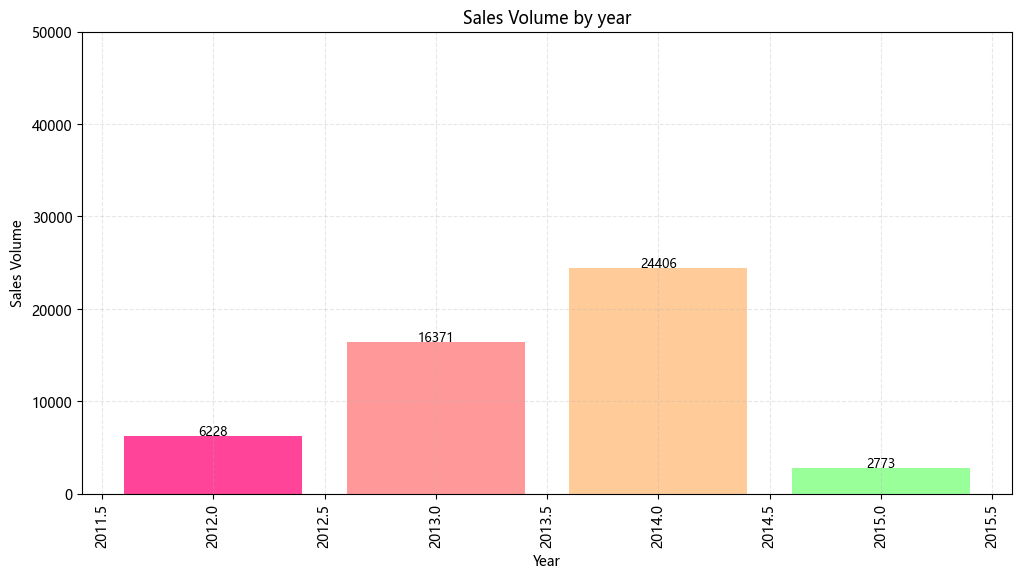

In [8]:
# Sales performance for each year
year_sales = mb_trade.groupby(['year'])['buy_mount'].sum()
colors = ['#ff4499','#ff9999','#ffcc99','#99ff99']
plt.figure(figsize = (12,6))
plt.bar(year_sales.index,year_sales.values,color = colors)
plt.title("Sales Volume by year")
plt.xlabel("Year")
plt.ylabel("Sales Volume")
plt.xticks(rotation=90)
plt.grid(True,alpha=0.3,linestyle='--')
plt.ylim([0,50000])
for x,y in zip(year_sales.index,year_sales.values):
    plt.text(x,y+ max(year_sales.values)*0.02,str(y),ha='center',va='center',fontsize=9)

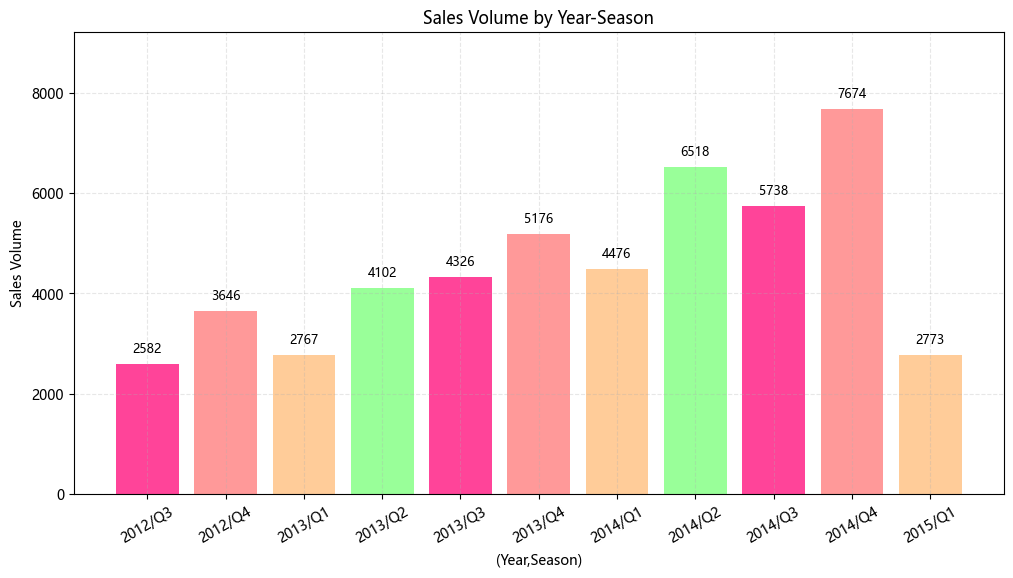

In [9]:
# Sales performance for each quarter in each year
year_quarter_sales = mb_trade.groupby(['year','quarter'])['buy_mount'].sum()
x_list = [str(i[0]) + "/Q" + str(i[1]) for i in year_quarter_sales.index]
y_list =year_quarter_sales.values.tolist()
plt.figure(figsize = (12,6))
plt.bar(x_list, y_list, color=colors )
plt.title("Sales Volume by Year-Season")
plt.xlabel("(Year,Season)")
plt.ylabel("Sales Volume")
plt.xticks(rotation=30)
plt.grid(True,alpha=0.3,linestyle='--')
plt.ylim([0,max(y_list)*1.2])
for x,y in zip(x_list,y_list):
    plt.text(x,y+5000*0.06,str(y),ha='center',va='center',fontsize=9)

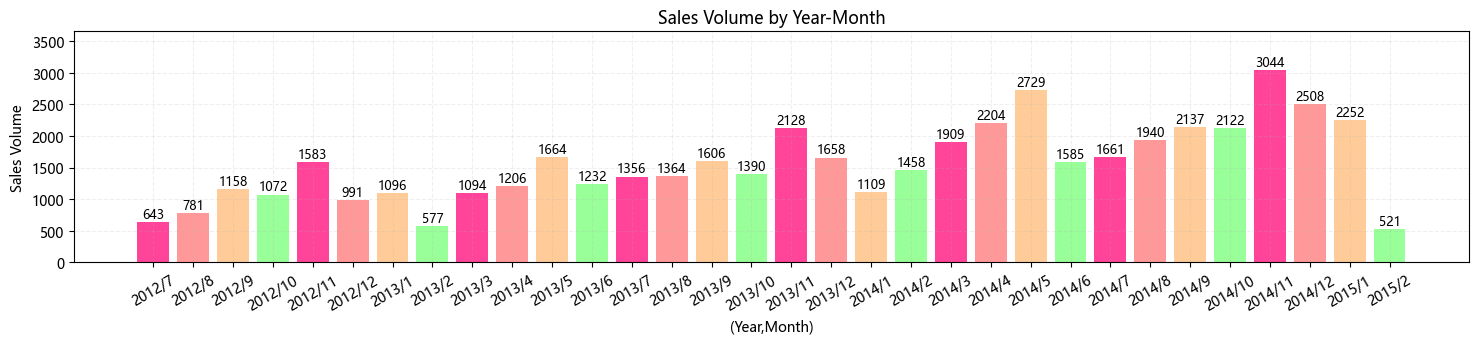

In [10]:
# # Sales performance for each month in each year
year_month_sales = mb_trade.groupby(['year','month'])['buy_mount'].sum()
x_list = [str(i[0]) + "/" + str(i[1]) for i in year_month_sales.index]
y_list =year_month_sales.values.tolist()
plt.figure(figsize = (18,3))
plt.bar(x_list, y_list, color=colors )
plt.title("Sales Volume by Year-Month")
plt.xlabel("(Year,Month)")
plt.ylabel("Sales Volume")
plt.xticks(rotation=30)
plt.grid(True,alpha=0.2,linestyle='--')
plt.ylim([0,max(y_list)*1.2])
for x,y in zip(x_list,y_list):
    plt.text(x,y+2000*0.06,str(y),ha='center',va='center',fontsize=9)

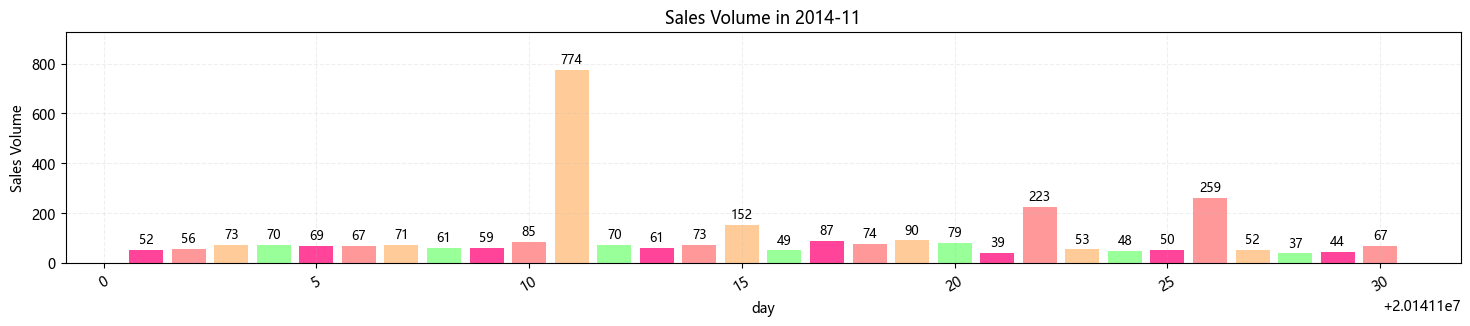

In [11]:
'''
    In each Q4, or to be more specific, in each November, the sales volume is much higher than the others, that might be caused by 11-11 promotional event. To clarify the impact of the event, select 2014/11 to analyst
'''
month_sales = mb_trade[ (mb_trade.year ==2014) & (mb_trade.month ==11) ].groupby(['day'])['buy_mount'].sum()
x_list = month_sales.index
y_list =month_sales.values
plt.figure(figsize = (18,3))
plt.bar(x_list, y_list, color=colors )
plt.title("Sales Volume in 2014-11")
plt.xlabel("day")
plt.ylabel("Sales Volume")
plt.xticks(rotation=30)
plt.grid(True,alpha=0.2,linestyle='--')
plt.ylim([0,max(y_list)*1.2])
for x,y in zip(x_list,y_list):
    plt.text(x,y+200*0.2,str(y),ha='center',va='center',fontsize=9)

### Catagery Analysis

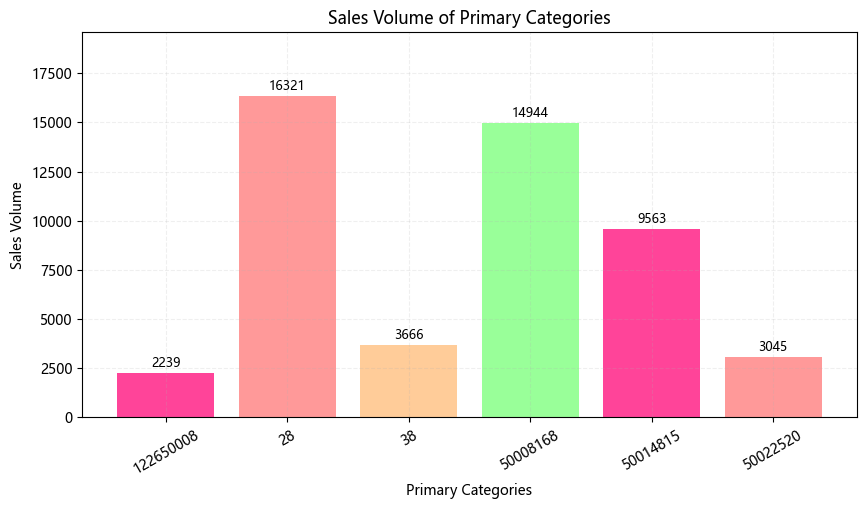

In [12]:
#Primary product categories analysis
cat1_sales = mb_trade.groupby(by = 'cat1')['buy_mount'].sum()
plt.figure(figsize = (10,5))
plt.bar(cat1_sales.index, cat1_sales.values, color=colors )
plt.title("Sales Volume of Primary Categories")
plt.xlabel("Primary Categories")
plt.ylabel("Sales Volume")
plt.xticks(rotation=30)
plt.grid(True,alpha=0.2,linestyle='--')
plt.ylim([0,max(cat1_sales.values)*1.2])
for x,y in zip(cat1_sales.index, cat1_sales.values):
    plt.text(x,y+2500*0.2,str(y),ha='center',va='center',fontsize=9)

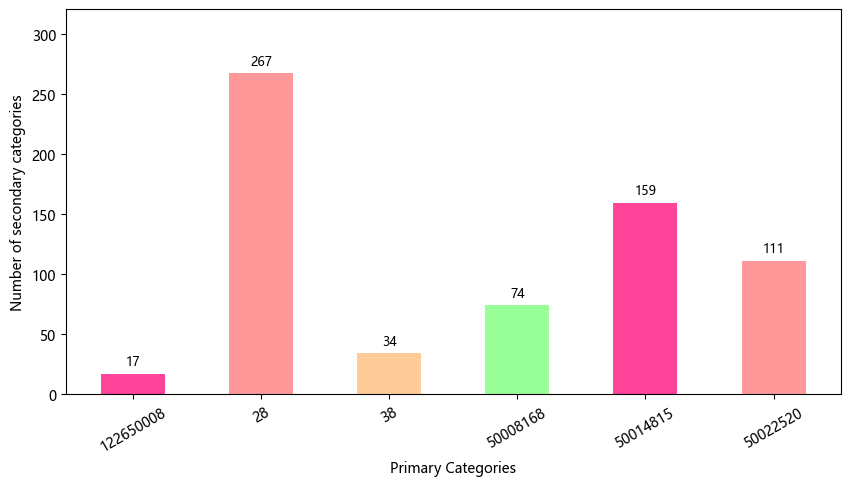

In [13]:
# The number of secondary categories in each primary category
cat2=mb_trade.groupby(['cat1'])['cat_id'].nunique()
plt.figure(figsize = (10,5))
plt.bar(cat2.index,cat2.values,width=0.5, color=colors)
plt.xlabel('Primary Categories')
plt.ylabel('Number of secondary categories')
plt.xticks(rotation=30)
plt.ylim([0,max(cat2.values)*1.2])
for x,y in zip(cat2.index, cat2.values):
    plt.text(x,y+50*0.2,str(y),ha='center',va='center',fontsize=9)

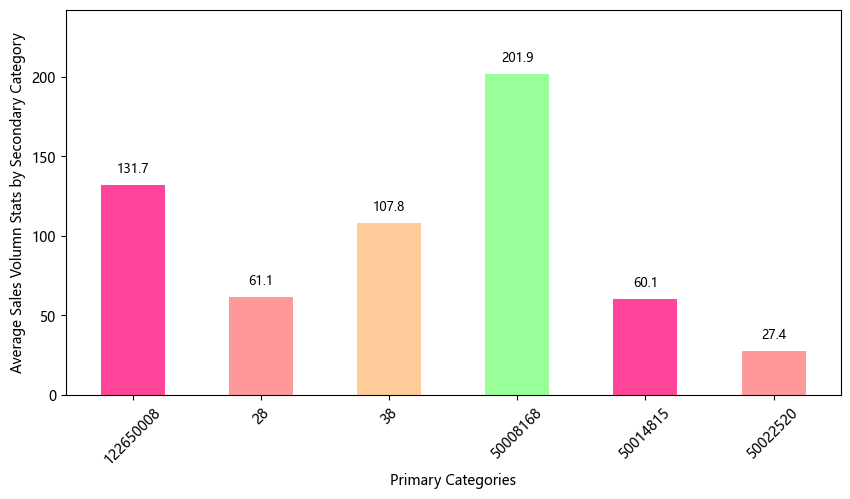

In [14]:
#The average sales contribution of each secondary category under a primary category
cat2_avg_contribution= (mb_trade.groupby(['cat1'])['buy_mount'].sum() / mb_trade.groupby(['cat1'])['cat_id'].nunique())
plt.figure(figsize = (10,5))
plt.bar(cat2_avg_contribution.index,cat2_avg_contribution.values,width=0.5, color=colors)
plt.xlabel('Primary Categories')
plt.ylabel('Average Sales Volumn Stats by Secondary Category')
plt.xticks(rotation=45)
plt.ylim([0,max(cat2_avg_contribution.values)*1.2])
for x,y in zip(cat2_avg_contribution.index, cat2_avg_contribution.values):
    plt.text(x,y+50*0.2,str(round(y,1)),ha='center',va='center',fontsize=9)

### Gender Analysis

In [15]:
# Merging two data into one DataFrame
mb_record = pd.merge(mb_trade,mb_info)
mb_record

,user_id,auction_id,cat_id,cat1,property,buy_mount,day,date,year,month,quarter,day_in_month,birthday,gender
0,513441334,19909384116,50010557,50008168,25935:21991;1628665:29784;22019:34731;22019:20...,1,20121212,2012-12-12,2012,12,4,12,2011-01-05,1
1,377550424,15771663914,50015841,28,1628665:3233941;1628665:3233942;3914866:11580;...,1,20121123,2012-11-23,2012,11,4,23,2011-06-20,1
2,47342027,14066344263,50013636,50008168,21458:21599;13585028:3416646;1628665:3233942;1...,1,20120911,2012-09-11,2012,9,3,11,2010-10-08,1
3,119784861,20796936076,50140021,50008168,21458:120325094;22019:2026;22019:34731;22019:3...,1,20121129,2012-11-29,2012,11,4,29,2012-03-27,0
4,159129426,15198386301,50013711,50008168,21458:11580;1628665:29778;22019:3340598;22019:...,2,20120808,2012-08-08,2012,8,3,8,2010-08-25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,379910739,12881672070,50012451,50008168,1628665:3233941;22019:3228688;22019:3265977;22...,2,20120904,2012-09-04,2012,9,3,4,2011-02-26,0
797,685332320,12781785338,50018831,50014815,21458:4348502;1629846:4344686;1828368:39447633...,2,20130601,2013-06-01,2013,6,2,1,2012-02-23,0
798,389326420,17164967407,50006820,28,21458:125625318;50167493:3366864;21475:2757081...,1,20140916,2014-09-16,2014,9,3,16,2013-07-17,0
799,1372572,16915013171,50008845,28,21458:30992;1628665:3233941;1628665:3233942;16...,1,20130327,2013-03-27,2013,3,1,27,2012-01-30,1


In [16]:
# Calculate children's age
# 直接在原DataFrame上筛选并赋值
mb_record['age'] = round((mb_record['date'] - mb_record['birthday']) / pd.Timedelta(days=365), 2)
mb_record = mb_record[mb_record['age'] >= 0].copy()

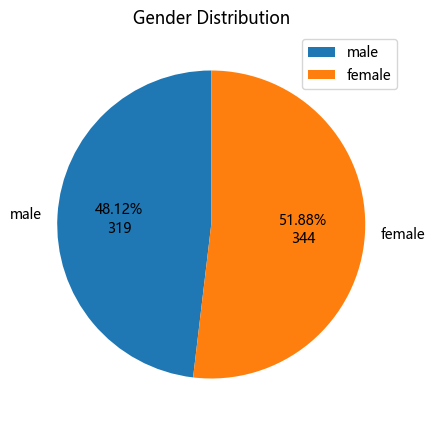

In [17]:
# gender ratio
def compute_fraction(pct, allvals):
    absolute = int(pct/100 * np.sum(allvals))
    return '{:.2f}%\n{:d}'.format(pct, absolute)
gender_info = mb_record.groupby('gender')['user_id'].count()
labels= ['male','female']
plt.figure(figsize = (5,5))
values = [gender_info.get(1,0),gender_info.get(0,1)]
plt.pie(values,labels=labels,autopct= lambda x: compute_fraction(x,values),startangle=90)
plt.legend(labels)
plt.title('Gender Distribution')
plt.show()

['50022520', '28', '50014815', '50008168', '38', '122650008']


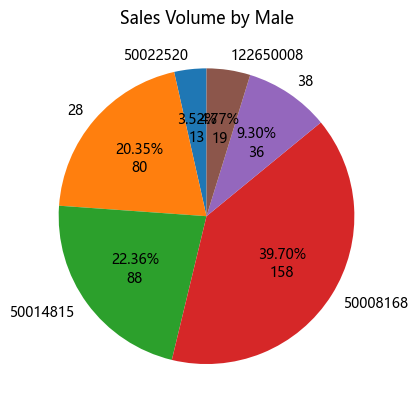

In [18]:
# The manifestation of gender in primary category sales
gender_trade = mb_record.groupby(['gender','cat1'])['buy_mount'].sum()
cat1_list = mb_trade['cat1'].unique().tolist()
print(cat1_list)
# 1. Category sales statistics for males
values = np.array([gender_trade.loc[(1,cat1)] for cat1 in cat1_list])
plt.pie(values,labels=cat1_list,startangle=90, autopct= lambda x: compute_fraction(x,values))
plt.title('Sales Volume by Male')
plt.show()

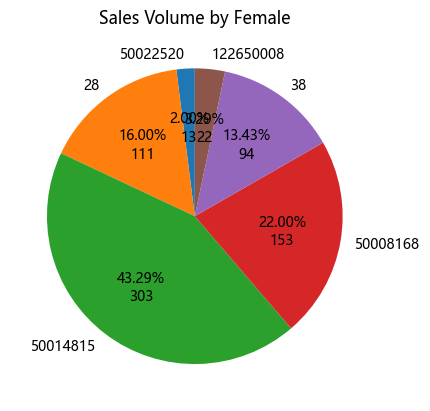

In [19]:
# 1. Category sales statistics for females
values = np.array([gender_trade.loc[(0,cat1)] for cat1 in cat1_list])
plt.pie(values,labels=cat1_list,startangle=90, autopct= lambda x: compute_fraction(x,values))
plt.title('Sales Volume by Female')
plt.show()